<a href="https://colab.research.google.com/github/UliksSekiraqa/StockMarketAnalysis/blob/master/Twitter_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install GetOldTweets3

### **Tweets Extraction**

In [ ]:
import GetOldTweets3 as got
import pandas as pd

In [ ]:
def get_tweets(keywords, location, start_date, end_date, max_tweets):
    df_tweet_all = pd.DataFrame()

    for keyword in keywords:
        print(keyword)
   
        # specifying tweets searching criteria 
        tweetCriteria = got.manager.TweetCriteria().setQuerySearch(keyword)\
                                   .setNear(location)\
                                   .setSince(start_date)\
                                   .setUntil(end_date)\
                                   .setMaxTweets(max_tweets)
        
        # scraping tweets based on criteria
        tweet = got.manager.TweetManager.getTweets(tweetCriteria)
        
        # extracting tweet attributes (specified in the list comprehension)
        text_tweets = [[tw.username,
                        tw.text,
                        tw.date,
                        tw.retweets,
                        tw.favorites,
                        tw.mentions,
                        tw.hashtags] for tw in tweet]

        df_tweet = pd.DataFrame(text_tweets)
        df_tweet['keyword'] = keyword
        df_tweet_all = df_tweet_all.append(df_tweet)
    
    df_tweet_all.columns = ['User','Text','Date','Favorites','Retweets','Mentions','HashTags', 'Search Keywords']
    
    return df_tweet_all

In [ ]:
keywords = ['covid',]
df = get_tweets(keywords, 'New York', start_date = "2020-06-01", end_date = "2020-06-30", max_tweets=1000).sort_values('Date',ascending=False)

df.head()

covid


,User,Text,Date,Favorites,Retweets,Mentions,HashTags,Search Keywords
0,oldschoolRUSH,A Paychic in my neighborhood just renewed her ...,2020-06-29 23:55:16+00:00,0,0,,,covid
1,marctorrence,It’s important work! I applied after reading a...,2020-06-29 23:51:25+00:00,0,1,,,covid
2,SergiyKyslytsya,"New York, once musicals capital of the world. ...",2020-06-29 23:48:47+00:00,0,6,,,covid
3,BSRC,A HUGE THANK YOU TO GBENGA AKINNAGBE'S LIBERAT...,2020-06-29 23:41:39+00:00,0,0,,,covid
4,TheNPSCG,The Impact of COVID-19 on the Nonprofit Sector...,2020-06-29 23:39:31+00:00,0,1,,,covid


In [ ]:
df.size

8000

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   User             1000 non-null   object             
 1   Text             1000 non-null   object             
 2   Date             1000 non-null   datetime64[ns, UTC]
 3   Favorites        1000 non-null   int64              
 4   Retweets         1000 non-null   int64              
 5   Mentions         1000 non-null   object             
 6   HashTags         1000 non-null   object             
 7   Search Keywords  1000 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2), object(5)
memory usage: 70.3+ KB


In [ ]:
# export results as an html file
df.to_html('news_twitter_summary.html')

### **Text cleaning**

1. Remove stopwords (including punctuations)
2. Lammetization/stemming: tranforming any form of a word to its root word
3. Tokenization: converting a sentence into list of words

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
import re
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [ ]:
def preprocess(text):
    # Remove link, user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
   
    for token in text.split():
        if token not in stop_words:
            tokens.append(stemmer.stem(token))
   
    return " ".join(tokens)

In [ ]:
df['Text'] = df['Text'].apply(lambda x: preprocess(x))

In [ ]:
df.head()

,User,Text,Date,Favorites,Retweets,Mentions,HashTags,Search Keywords
0,oldschoolRUSH,paychic neighborhood renew leas covid 19 good,2020-06-29 23:55:16+00:00,0,0,,,covid
1,marctorrence,import work appli read articl poll worker olde...,2020-06-29 23:51:25+00:00,0,1,,,covid
2,SergiyKyslytsya,new york music capit world anymor anoth one co...,2020-06-29 23:48:47+00:00,0,6,,,covid
3,BSRC,huge thank gbenga akinnagb liber peopl covid c...,2020-06-29 23:41:39+00:00,0,0,,,covid
4,TheNPSCG,impact covid 19 nonprofit sector npscg,2020-06-29 23:39:31+00:00,0,1,,,covid


In [ ]:
df.to_html('news_twitter_summary.html')

In [ ]:
df.to_csv('tweets.csv')

Sentiment140 kernal:
https://www.kaggle.com/arunrk7/nlp-beginner-text-classification-using-lstm


### **Training a text classification model using the *Sentiment140* dataset**

####**Step 1. Load the dataset**

In [33]:
from google.colab import files
uploaded = files.upload()

Saving sentiment140.csv to sentiment140.csv


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [41]:
# the 'target' column is the labeled sentiment
DATASET_COLUMNS = ["target", "id", "date", "flag", "user", "text"] 
sentiment = pd.read_csv('sentiment140.csv', names=DATASET_COLUMNS, encoding='latin', 
                        engine='python', error_bad_lines=False)

sentiment.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [42]:
# train only on 'text' to classify the 'sentiment'
sentiment = sentiment.drop(['id', 'date', 'flag', 'user'], axis=1)
sentiment

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [37]:
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   text    1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [38]:
sentiment['target'].unique()

array([0, 4])

In [43]:
# label the sentiment: [0]: Negative, [4]: Positive
label_to_sentiment = {0:'Negative', 4:'Positive'}

def label_decoder(label):
    return label_to_sentiment[label]
sentiment['target'] = sentiment['target'].apply(lambda x: label_decoder(x))

sentiment

,target,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

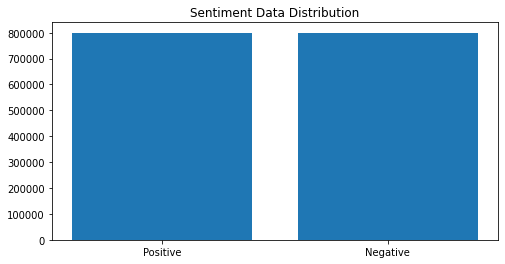

In [44]:
val_count = sentiment['target'].value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

As can be seen, the dataset dose not have any skewness, which is ideal.

###**Step 2. Text Preprocessing**
1. Remove stopwords, punctuations, hyperlinks and mentions
2. Lammetization/stemming: tranforming any form of a word to its root word

In [45]:
import re
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [46]:
def preprocess(text):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
   
    for token in text.split():
        if token not in stop_words:
            tokens.append(stemmer.stem(token))
   
    return " ".join(tokens)

In [48]:
sentiment['text'] = sentiment['text'].apply(lambda x: preprocess(x))
sentiment

,target,text
0,Negative,awww bummer shoulda got david carr third day
1,Negative,upset updat facebook text might cri result sch...
2,Negative,dive mani time ball manag save 50 rest go bound
3,Negative,whole bodi feel itchi like fire
4,Negative,behav mad see
...,...,...
1599995,Positive,woke school best feel ever
1599996,Positive,thewdb com cool hear old walt interview
1599997,Positive,readi mojo makeov ask detail
1599998,Positive,happi 38th birthday boo alll time tupac amaru ...


**Word cloud visualizations of the pre-processed positive and negative words.**

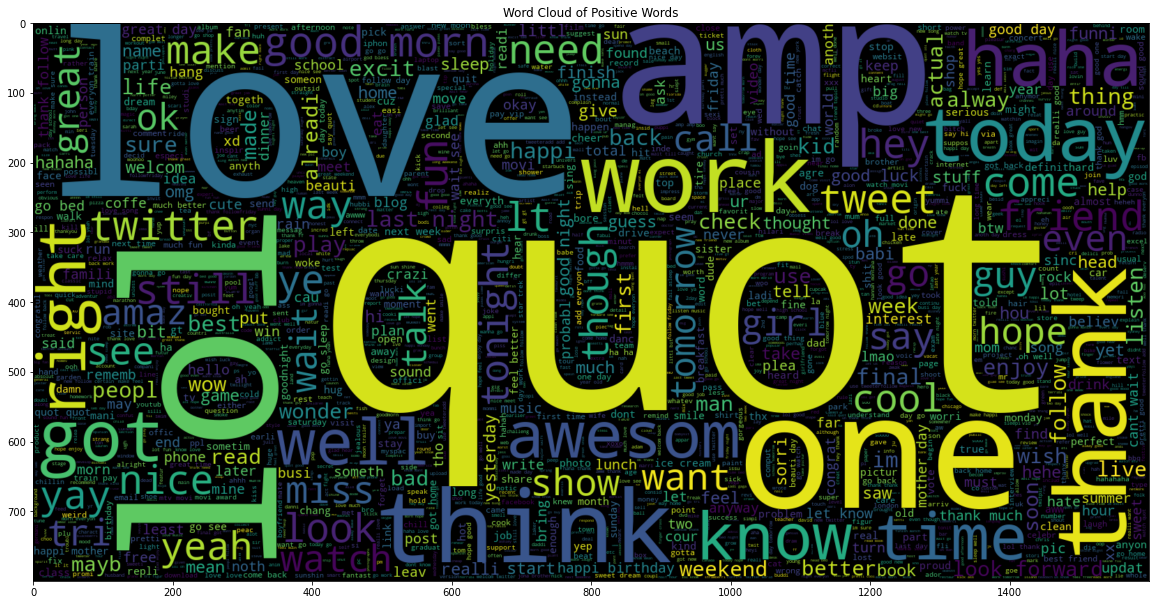

In [49]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800)\
              .generate(" ".join(sentiment[sentiment['target'] == 'Positive']['text']))
plt.title("Word Cloud of Positive Words")
plt.imshow(wc , interpolation = 'bilinear')

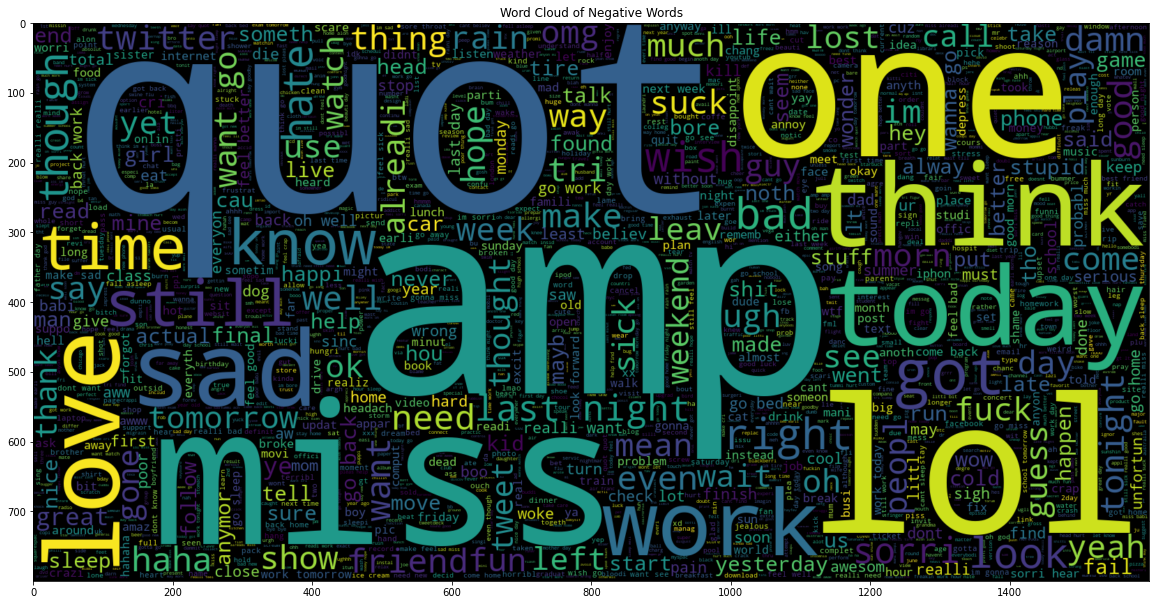

In [51]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800)\
              .generate(" ".join(sentiment[sentiment['target'] == 'Negative']['text']))
plt.title("Word Cloud of Negative Words")
plt.imshow(wc , interpolation = 'bilinear')

####**Step 3. Split train and test dataset**

In [52]:
from sklearn.model_selection import train_test_split

TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000

In [54]:
sentiment_train, sentiment_test = train_test_split(sentiment, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(sentiment_train))
print("TEST size:", len(sentiment_test))

TRAIN size: 1280000
TEST size: 320000


**Check the distribution of positive and negative tweets in testing & training dataset.**

In [56]:
y = pd.DataFrame(sentiment_train, columns=['target'])

print("Checking the training set:")
print(len(y.loc[sentiment['target'] == "Positive"]) / len(y) * 100)
print(len(y.loc[sentiment['target'] == "Negative"]) / len(y) * 100)

Checking the training set:
49.96046875
50.03953125


In [58]:
y_ = pd.DataFrame(sentiment_test, columns=['target'])

print("Checking the testing set:")
print(len(y_.loc[sentiment['target'] == "Positive"]) / len(y_) * 100)
print(len(y_.loc[sentiment['target'] == "Negative"]) / len(y_) * 100)

Checking the testing set:
50.158125
49.841875


As can be seen, the split is correct since both training and testing set keep the original proportion of Positive:Negative tweets (which is nearly 1:1).

####**Step 4. Tokenization:** Chopping a character sequence up into pieces (tokens).

In [105]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentiment_train['text'])

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 248736


In [118]:
# Pad the tweets to ensure there is no variance on count of words in them.
from keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 30

x_train = pad_sequences(tokenizer.texts_to_sequences(sentiment_train['text']),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(sentiment_test['text']),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape: ", x_train.shape)
print("Testing X Shape: ", x_test.shape)

Training X Shape:  (1280000, 30)
Testing X Shape:  (320000, 30)


###**Step 5. Label Encoding**

In [64]:
labels = sentiment_train['target'].unique().tolist()
labels

['Positive', 'Negative']

In [94]:
encoder = LabelEncoder()
encoder.fit(sentiment_train['target'].to_list())

y_train = encoder.transform(sentiment_train['target'].to_list())
y_test = encoder.transform(sentiment_test['target'].to_list())

# reshape the results to be in 1D
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


###**Step 6. Word Emdedding** using Word2Vec

In [67]:
import gensim

W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

In [68]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [69]:
documents = [_text.split() for _text in sentiment_train['text']]
w2v_model.build_vocab(documents)

In [76]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size: ", vocab_size)

Vocab size 23654


In [77]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(259088479, 295270528)

In [78]:
w2v_model.wv.most_similar("love")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('amaz', 0.5858823657035828),
 ('luv', 0.529019832611084),
 ('awesom', 0.5161921977996826),
 ('looov', 0.5047914385795593),
 ('ador', 0.46369171142578125),
 ('beauti', 0.4302016496658325),
 ('lovee', 0.42214900255203247),
 ('loveeee', 0.4173901081085205),
 ('great', 0.41216349601745605),
 ('loov', 0.4034198224544525)]

In [83]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

print(embedding_matrix.shape)

(248736, 300)


In [84]:
from keras.layers import Embedding

embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False)

###**Step 7. Model Training** using LSTM
Model used: **Sequence Models**

For model architecture, we use
1. Embedding Layer - Generating Embedding Vector for each input sequence.
2. Conv1D Layer - Convolving data into smaller feature vectors.
3. LSTM (Long Short Term Memory) - A variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.
4. Dense - Fully Connected Layers for classification

In [86]:
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense

In [87]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 300)           74620800  
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 74,781,301
Trainable params: 160,501
Non-trainable params: 74,620,800
_________________________________________________________________


In [88]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [90]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

####**Train**

In [91]:
# Train
BATCH_SIZE = 1024
EPOCHS = 8

history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
1152000/1152000 [==============================] - 939s 815us/step - loss: 0.5073 - accuracy: 0.7483 - val_loss: 0.4685 - val_accuracy: 0.7760
Epoch 2/8


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1152000/1152000 [==============================] - 938s 814us/step - loss: 0.4842 - accuracy: 0.7637 - val_loss: 0.4628 - val_accuracy: 0.7801
Epoch 3/8
1152000/1152000 [==============================] - 935s 812us/step - loss: 0.4779 - accuracy: 0.7681 - val_loss: 0.4587 - val_accuracy: 0.7831
Epoch 4/8
1152000/1152000 [==============================] - 933s 810us/step - loss: 0.4747 - accuracy: 0.7700 - val_loss: 0.4573 - val_accuracy: 0.7837
Epoch 5/8
1152000/1152000 [==============================] - 934s 811us/step - loss: 0.4722 - accuracy: 0.7717 - val_loss: 0.4559 - val_accuracy: 0.7842
Epoch 6/8
1152000/1152000 [==============================] - 927s 805us/step - loss: 0.4702 - accuracy: 0.7731 - val_loss: 0.4536 - val_accuracy: 0.7857
Epoch 7/8
1152000/1152000 [==============================] - 937s 813us/step - loss: 0.4690 - accuracy: 0.7739 - val_loss: 0.4539 - val_accuracy: 0.7861
Epoch 8/8
1152000/1152000 [==============================] - 943s 819us/step - loss: 0.4679 

####**Evaluation**

In [95]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

print("Accury:",score[1])
print("Loss:",score[0])

320000/320000 [==============================] - 84s 261us/step
Accury: 0.7883531451225281
Loss: 0.44948426909446715


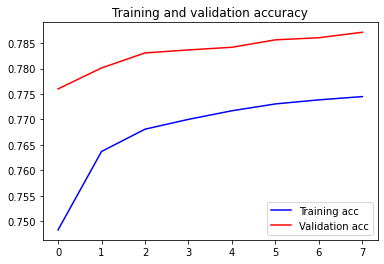

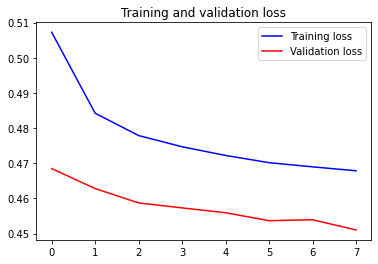

In [98]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

####**Predict**

In [103]:
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

In [100]:
def decode_sentiment(score):       
    label = NEUTRAL
    if score <= SENTIMENT_THRESHOLDS[0]:
        label = NEGATIVE
    elif score >= SENTIMENT_THRESHOLDS[1]:
        label = POSITIVE

    return label

In [115]:
def predict(text):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score)}  

In [116]:
predict("I love the music")

{'label': 'POSITIVE', 'score': 0.9680293202400208}

In [119]:
predict("I hate the rain")

{'label': 'NEGATIVE', 'score': 0.00993043091148138}

In [123]:
predict("i don't know what i'm doing")

{'label': 'NEGATIVE', 'score': 0.3603038787841797}

####**Confusion Matrix**

In [124]:
y_pred_1d = []
y_test_1d = list(sentiment_test['target'])
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score) for score in scores]

320000/320000 [==============================] - 77s 239us/step


In [135]:
from sklearn import metrics

metrics.confusion_matrix(y_test_1d, y_pred_1d)

array([[     0,      0,      0,      0,      0],
       [     0,      0,      0,      0,      0],
       [114516,  28392,      0,  16586,      0],
       [     0,      0,      0,      0,      0],
       [ 24278,  34859,      0, 101369,      0]])

In [131]:
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)
    
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


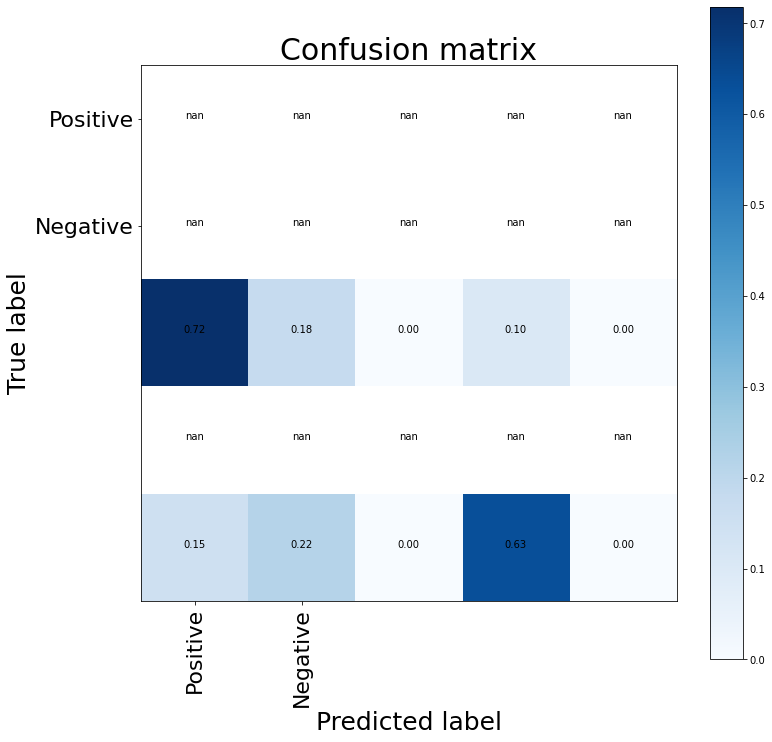

In [132]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=sentiment_train['target'].unique(), title="Confusion matrix")
plt.show()

In [134]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_test_1d, y_pred_1d))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    NEGATIVE       0.00      0.00      0.00       0.0
     NEUTRAL       0.00      0.00      0.00       0.0
    Negative       0.00      0.00      0.00  159494.0
    POSITIVE       0.00      0.00      0.00       0.0
    Positive       0.00      0.00      0.00  160506.0

    accuracy                           0.00  320000.0
   macro avg       0.00      0.00      0.00  320000.0
weighted avg       0.00      0.00      0.00  320000.0



###**Save models**

In [141]:
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [142]:
import pickle

model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


##**Predict the sentiment of tweets**

In [146]:
df = df.drop(columns=['User', 'Date', 'Favorites', 'Retweets', 'Mentions', 'HashTags'])
df

,Text,Search Keywords
0,paychic neighborhood renew leas covid 19 good,covid
1,import work appli read articl poll worker olde...,covid
2,new york music capit world anymor anoth one co...,covid
3,huge thank gbenga akinnagb liber peopl covid c...,covid
4,impact covid 19 nonprofit sector npscg,covid
...,...,...
995,enter offic mask requir upon entri one give co...,covid
996,wish covid thing realli wanna pack bag travel ...,covid
997,covid case nyc hospit spike,covid
998,sick plan defeat covid 19 talk lie bs america ...,covid


In [164]:
df['Sentiment'] = np.nan
df['Score'] = np.nan

for i in df.index.values:
    prediction = predict(df.loc[i,'Text'])
    df.loc[i,'Sentiment'] = prediction.get('label')
    df.loc[i,'Score'] = prediction.get('score')
df

,Text,Search Keywords,Sentiment,Score
0,paychic neighborhood renew leas covid 19 good,covid,NEUTRAL,0.574920
1,import work appli read articl poll worker olde...,covid,NEUTRAL,0.488577
2,new york music capit world anymor anoth one co...,covid,NEGATIVE,0.212862
3,huge thank gbenga akinnagb liber peopl covid c...,covid,POSITIVE,0.821539
4,impact covid 19 nonprofit sector npscg,covid,POSITIVE,0.784934
...,...,...,...,...
995,enter offic mask requir upon entri one give co...,covid,NEUTRAL,0.537155
996,wish covid thing realli wanna pack bag travel ...,covid,NEGATIVE,0.060427
997,covid case nyc hospit spike,covid,NEGATIVE,0.269855
998,sick plan defeat covid 19 talk lie bs america ...,covid,NEGATIVE,0.031435


In [189]:
months = ['Nov 2019','Dec 2019','Jan 2020','Feb 2020','Mar 2020','Apr 2020','May 2020', 'Jun 2020']
all_sentiments = pd.DataFrame(index=months, columns=['POSITIVE','NEUTRAL','NEGATIVE'])
all_sentiments

,POSITIVE,NEUTRAL,NEGATIVE
Nov 2019,NaN,NaN,NaN
Dec 2019,NaN,NaN,NaN
Jan 2020,NaN,NaN,NaN
Feb 2020,NaN,NaN,NaN
Mar 2020,NaN,NaN,NaN
Apr 2020,NaN,NaN,NaN
May 2020,NaN,NaN,NaN
Jun 2020,NaN,NaN,NaN


In [190]:
pos = len(df.loc[df['Sentiment'] == POSITIVE]) / len(df) * 100
neg = len(df.loc[df['Sentiment'] == NEGATIVE]) / len(df) * 100
neu = len(df.loc[df['Sentiment'] == NEUTRAL]) / len(df) * 100

all_sentiments.loc['Jun 2020','POSITIVE'] = pos
all_sentiments.loc['Jun 2020','NEGATIVE'] = neg
all_sentiments.loc['Jun 2020','NEUTRAL'] = neu

In [191]:
all_sentiments

,POSITIVE,NEUTRAL,NEGATIVE
Nov 2019,NaN,NaN,NaN
Dec 2019,NaN,NaN,NaN
Jan 2020,NaN,NaN,NaN
Feb 2020,NaN,NaN,NaN
Mar 2020,NaN,NaN,NaN
Apr 2020,NaN,NaN,NaN
May 2020,NaN,NaN,NaN
Jun 2020,22.2,34.9,42.9


### **Tweets Extraction**

In [203]:
import GetOldTweets3 as got
import pandas as pd

In [209]:
def get_tweets(keywords, location, start_date, end_date, max_tweets):
    df_tweet_all = pd.DataFrame()

    for keyword in keywords:
        print(keyword)
   
        # specifying tweets searching criteria 
        tweetCriteria = got.manager.TweetCriteria().setQuerySearch(keyword)\
                                   .setNear(location)\
                                   .setSince(start_date)\
                                   .setUntil(end_date)\
                                   .setMaxTweets(max_tweets)
        
        # scraping tweets based on criteria
        tweet = got.manager.TweetManager.getTweets(tweetCriteria)
        
        # extracting tweet attributes (specified in the list comprehension)
        text_tweets = [[tw.username,
                        tw.text,
                        tw.date,
                        tw.retweets,
                        tw.favorites,
                        tw.mentions,
                        tw.hashtags] for tw in tweet]

        df_tweet = pd.DataFrame(text_tweets)
        df_tweet['keyword'] = keyword
        df_tweet_all = df_tweet_all.append(df_tweet)
    
    df_tweet_all.columns = ['User','Text','Date','Favorites','Retweets','Mentions','HashTags','Search Keywords']
    
    return df_tweet_all

In [214]:
keywords = ['covid']

df = get_tweets(keywords, 'New York', start_date = "2019-11-01", end_date = "2019-11-30", max_tweets=1000).sort_values('Date',ascending=False)
df.to_csv('Tweets Nov 2019.csv')
print("Fetched tweets in Nov 2019.")

df = get_tweets(keywords, 'New York', start_date = "2019-12-01", end_date = "2019-12-31", max_tweets=1000).sort_values('Date',ascending=False)
df.to_csv('Tweets Dec 2019.csv')
print("Fetched tweets in Dec 2019.")

df = get_tweets(keywords, 'New York', start_date = "2020-01-01", end_date = "2020-01-31", max_tweets=1000).sort_values('Date',ascending=False)
df.to_csv('Tweets Jan 2020.csv')
print("Fetched tweets in Jan 2020.")

df = get_tweets(keywords, 'New York', start_date = "2020-02-01", end_date = "2020-02-29", max_tweets=1000).sort_values('Date',ascending=False)
df.to_csv('Tweets Feb 2020.csv')
print("Fetched tweets in Feb 2020.")

df = get_tweets(keywords, 'New York', start_date = "2020-03-01", end_date = "2020-03-31", max_tweets=1000).sort_values('Date',ascending=False)
df.to_csv('Tweets Mar 2020.csv')
print("Fetched tweets in Mar 2020.")

df = get_tweets(keywords, 'New York', start_date = "2020-04-01", end_date = "2020-04-30", max_tweets=1000).sort_values('Date',ascending=False)
df.to_csv('Tweets Apr 2020.csv')
print("Fetched tweets in Apr 2020.")

df = get_tweets(keywords, 'New York', start_date = "2020-05-01", end_date = "2020-05-31", max_tweets=1000).sort_values('Date',ascending=False)
df.to_csv('Tweets May 2020.csv')
print("Fetched tweets in May 2020.")

df = get_tweets(keywords, 'New York', start_date = "2020-06-01", end_date = "2020-06-30", max_tweets=1000).sort_values('Date',ascending=False)
df.to_csv('Tweets Jun 2020.csv')
print("Fetched tweets in Jun 2020.")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


covid
Fetched tweets in Nov 2019.
covid
Fetched tweets in Dec 2019.


In [ ]:
df.size

8000

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   User             1000 non-null   object             
 1   Text             1000 non-null   object             
 2   Date             1000 non-null   datetime64[ns, UTC]
 3   Favorites        1000 non-null   int64              
 4   Retweets         1000 non-null   int64              
 5   Mentions         1000 non-null   object             
 6   HashTags         1000 non-null   object             
 7   Search Keywords  1000 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2), object(5)
memory usage: 70.3+ KB


In [ ]:
# export results as an html file
df.to_html('news_twitter_summary.html')

In [216]:
def get_sentiment(time_period):
    filename = "Tweets " + time_period + ".csv"
    tweets = pd.read_csv(filename, index_col=0)
    tweets.head()
    
    tweets['Text'] = tweets['Text'].apply(lambda x: preprocess(x))
    tweets = tweets.drop(columns=['User', 'Date', 'Favorites', 'Retweets', 'Mentions', 'HashTags'])

    tweets['Sentiment'] = np.nan
    tweets['Score'] = np.nan

    for i in tweets.index.values:
        prediction = predict(tweets.loc[i,'Text'])
        tweets.loc[i,'Sentiment'] = prediction.get('label')
        tweets.loc[i,'Score'] = prediction.get('score')

    pos = len(tweets.loc[tweets['Sentiment'] == POSITIVE]) / len(tweets) * 100
    neg = len(tweets.loc[tweets['Sentiment'] == NEGATIVE]) / len(tweets) * 100
    neu = len(tweets.loc[tweets['Sentiment'] == NEUTRAL]) / len(tweets) * 100

    all_sentiments.loc[time_period,'POSITIVE'] = pos
    all_sentiments.loc[time_period,'NEGATIVE'] = neg
    all_sentiments.loc[time_period,'NEUTRAL'] = neu


In [230]:
# time_periods = ['Nov 2019','Dec 2019','Jan 2020','Feb 2020','Mar 2020','Apr 2020','May 2020', 'Jun 2020']
# for time_period in time_periods:
#     print(time_period)
#     get_sentiment(time_period)

get_sentiment("Jan 2020")

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


ZeroDivisionError: ignored

In [229]:
all_sentiments

,POSITIVE,NEUTRAL,NEGATIVE
Nov 2019,NaN,NaN,NaN
Dec 2019,NaN,NaN,NaN
Jan 2020,NaN,NaN,NaN
Feb 2020,28.0374,29.9065,42.0561
Mar 2020,30.7,29.9,39.4
Apr 2020,32.3,30.8,36.9
May 2020,25.5,34.1,40.4
Jun 2020,22.2,34.9,42.9


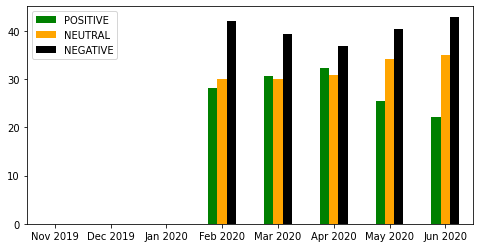

In [232]:
all_sentiments.plot.bar(rot=0, figsize=(8,4), color=['green','orange','black'])